In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image

from src import *
from tqdm.notebook import tqdm

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
model, config = load_model_locally('clean_cross_validation_5_small_features/2', 'rvce')

In [4]:
print('training')
for f in config.training_files:
    print(f)

print('\ntesting')
for f in config.testing_files:
    print(f)

training
20190819-Kutna Hora-L1-out-MVI_0007
20190819-Kutna Hora-L3-in-MVI_0005
20190819-Kutna Hora-L6-out-MVI_0017
20190819-Kutna Hora-L7-out-MVI_0032
20190819-Kutna Hora-L9-in-MVI_0043
20190819-Kutna Hora-L13-in-MVI_0006
20190819-Kutna Hora-L14-out-MVI_0005
20190819-Kutna Hora-L15-out-MVI_0012
20190819-Ricany-L2-in-MVI_0006
20190819-Ricany-L6-out-MVI_0011
20190819-Ricany-L7-in-MVI_0008
20190819-Ricany-L8-in-MVI_0009
20190819-Ricany-L8-out-MVI_0013
20190819-Ricany-L9-in-MVI_0008

testing
20190819-Kutna Hora-L3-out-MVI_0008
20190819-Kutna Hora-L18-in-MVI_0030
20190819-Ricany-L6-in-MVI_0008
20190819-Ricany-L9-out-MVI_0011


In [40]:
# model, config = load_model_locally('one_location_gaussian_blur', 'rvce')
# model, config = load_model_locally('one_location', 'rvce')
model, config = load_model_locally('clean_cross_validation_5_small_features/2', 'rvce')
model = model.to('cpu')

# file = '12_RX100'
file = '20190819-Kutna Hora-L1-out-MVI_0007'
# file = '20190819-Kutna Hora-L3-out-MVI_0008'

datapool = DataPool([file], config.window_length, config.split_ratio, tqdm=tqdm)
signal = datapool[file].signal
events = datapool[file].events
samples, labels = create_dataset_sequentially(signal, config.sr, events, window_length=config.window_length)
# config.f_max = None
# config.sr = 22050
transform = create_transformation(config)

Video loading:   0%|          | 0/1 [00:00<?, ?it/s]

0: 0.0008
1: 0.8253
2: 0.1711
3: 0.0027
4: 0.0001

true: 1
pred: 1


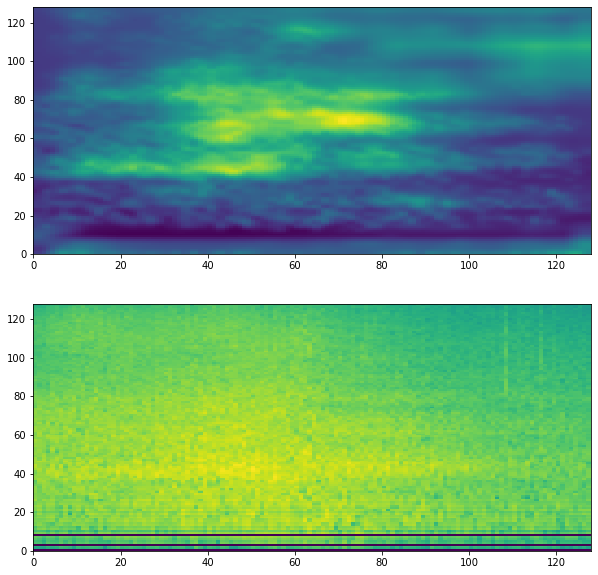

0: 0.0591
1: 0.9326
2: 0.0078
3: 0.0004
4: 0.0000

true: 1
pred: 1


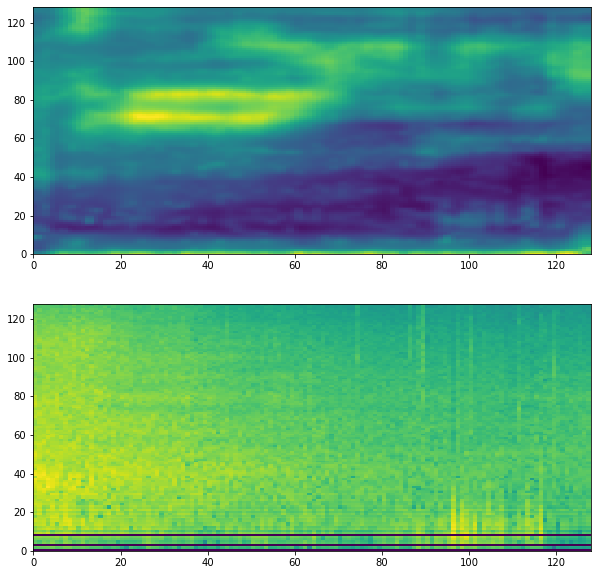

0: 0.0650
1: 0.8905
2: 0.0432
3: 0.0010
4: 0.0001

true: 1
pred: 1


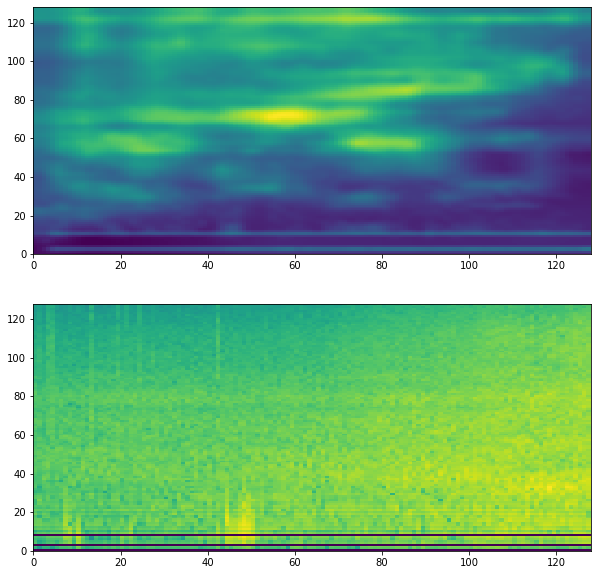

0: 0.0112
1: 0.8616
2: 0.0905
3: 0.0299
4: 0.0054

true: 1
pred: 1


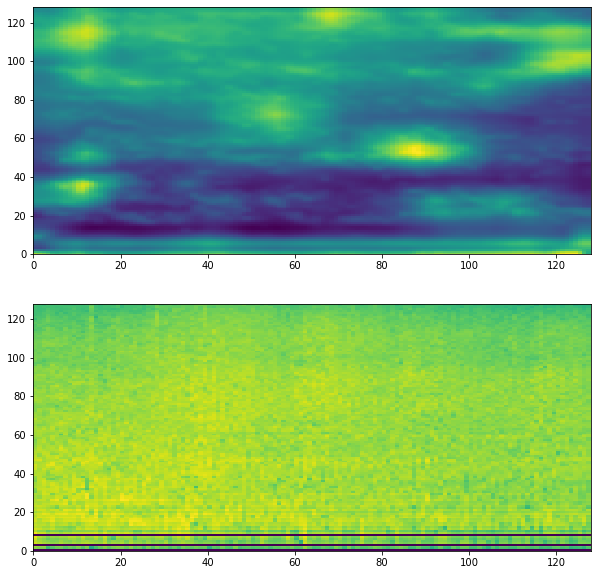

0: 0.0117
1: 0.9653
2: 0.0203
3: 0.0023
4: 0.0002

true: 1
pred: 1


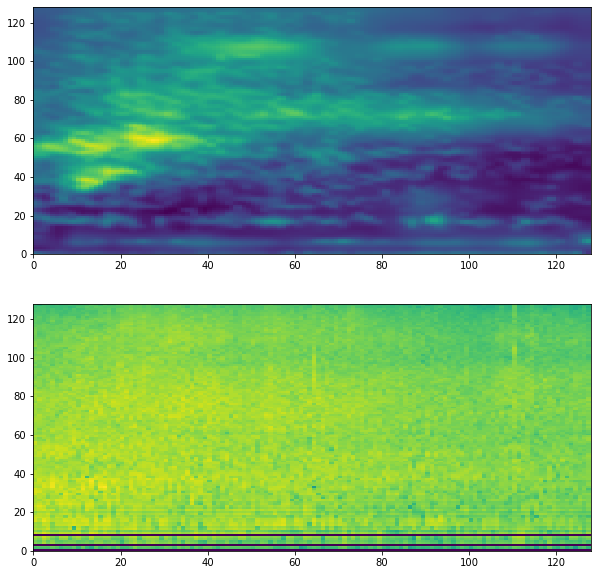

In [41]:
def visualize(label, sample):
    i = np.flatnonzero(np.array(labels) == label)[sample]
    sample = samples[i] 
    config.gaussian_blur = 0
    transform = create_transformation(config)
    input_tensor = transform(sample)
    input_batch = input_tensor.unsqueeze(0)
    
    for i, j in enumerate(model(input_batch).softmax(1)[0, :5].tolist()):
        print(f'{i}: {j:.4f}')
    print(f'\ntrue: {label}\npred: {model(input_batch).argmax(1).item()}')

    target_layers = [model.model.layer4[-1]]
    target_layers = [
        model.model.conv1,
        model.model.layer1,
        model.model.layer2,
        model.model.layer3,
        model.model.layer4
    ]

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    targets = [ClassifierOutputTarget(label)]

    grayscale_cam = cam(input_tensor=input_batch, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    fig, axes = plt.subplots(2, 1, figsize=(10,10))
    axes[0].pcolormesh(grayscale_cam)
    axes[1].pcolormesh(input_tensor[0]);
    plt.show()

for i in range(5):
    visualize(1, i)

In [14]:
label = 2
i = np.flatnonzero(np.array(labels) == label)[0]
print(i)
# volume_transform = torchaudio.transforms.Vol(0, 'db')
# sample = volume_transform(samples[i])
sample = samples[i] 
config.gaussian_blur = 0
transform = create_transformation(config)
input_tensor = transform(sample)
input_batch = input_tensor.unsqueeze(0)

5


In [15]:
# sample1 = samples[i] * 20
# transform = create_transformation(config)
# input_tensor_1 = transform(sample1)

In [16]:
# fig, axes = plt.subplots(2, 1, figsize=(10,10))
# vmin = min(input_tensor[0].min(), input_tensor_1[0].min())
# vmax = max(input_tensor[0].max(), input_tensor_1[0].max())
# axes[0].pcolormesh(input_tensor[0], vmin=vmin, vmax=vmax)
# axes[1].pcolormesh(input_tensor_1[0], vmin=vmin, vmax=vmax);


In [17]:
# plt.figure(figsize=(20,10))
# plt.pcolormesh(input_tensor_1[0] - input_tensor[0])
# plt.colorbar();

In [18]:
for i, j in enumerate(model(input_batch).softmax(1)[0, :5].tolist()):
    print(f'{i}: {j:.4f}')
print('\nPredicted:', model(input_batch).argmax(1).item())

0: 0.0005
1: 0.1306
2: 0.3709
3: 0.4192
4: 0.0752

Predicted: 3


In [19]:
target_layers = [model.model.layer4[-1]]
target_layers = [
    model.model.conv1,
    model.model.layer1,
    model.model.layer2,
    model.model.layer3,
    model.model.layer4
]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(label)]
# targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_batch, targets=targets, aug_smooth=True)
grayscale_cam = cam(input_tensor=input_batch, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
image_array = input_tensor.numpy().transpose(1,2,0)
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
visualization = show_cam_on_image(image_array, grayscale_cam, use_rgb=True)

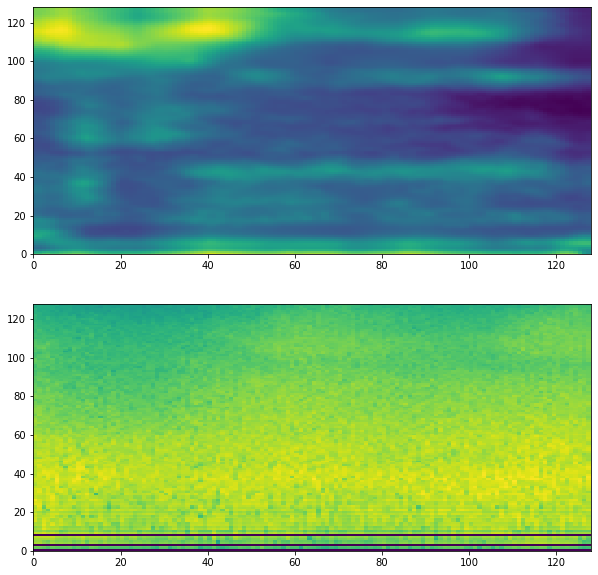

In [20]:
# plt.figure(figsize=(10,5))
fig, axes = plt.subplots(2, 1, figsize=(10,10))
# axes[0].imshow(grayscale_cam, aspect='auto');
# axes[1].imshow(input_tensor[0], aspect='auto');
# for ax in axes:
#     ax.invert_yaxis()
axes[0].pcolormesh(grayscale_cam)
axes[1].pcolormesh(input_tensor[0]);

# Imagenet example

In [236]:
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

filename = 'mushroom_strawberries.jpeg'
input_image = Image.open(filename)
input_tensor = preprocess(input_image)


input_batch = normalize(input_tensor).unsqueeze(0)

In [259]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [363]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50


model = resnet18(pretrained=True)
target_layers = [model.conv1]
target_layers = [model.layer4[1]]
target_layers = [
    model.conv1, 
    model.layer1, 
    model.layer2, 
    model.layer3, 
    model.layer4
]


# input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(947)]
targets = [ClassifierOutputTarget(949)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_batch, targets=targets, aug_smooth=True)
grayscale_cam = cam(input_tensor=input_batch, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
image_array = input_tensor.numpy().transpose(1,2,0)
visualization = show_cam_on_image(image_array, grayscale_cam, use_rgb=True)

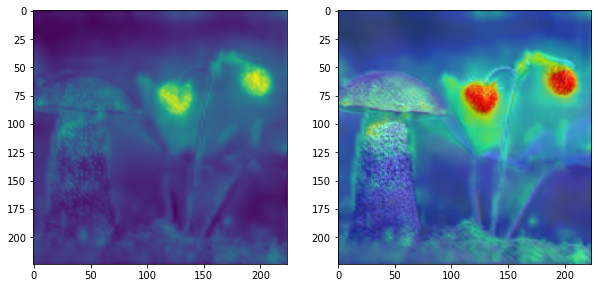

In [364]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(grayscale_cam)
axes[1].imshow(visualization);